In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution

In [2]:
# TODO: Cleanup and move upward

from qiskit import execute, Aer
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit import transpile
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor

from qiskit.circuit.library import PhaseGate

In [3]:
# TODO: Rename all lambdas to lambda_ to avoid conflict with Python keyword
#       Alternatively use letter h
#       Turn lambda (also n?) into ndarrays

n = 4
lambd = 1.2

In [4]:
# TODO: Is theta a good name? Find out if this angle is called anything in particular


def theta(n: int, k: int, lambda_: float) -> float:
    theta = 2 * np.pi * k / n
    x = np.cos(theta)
    y = np.sin(theta)

    return np.arccos((lambda_ - x) / np.sqrt((lambda_ - x) ** 2 + y**2))

In [5]:
# This cell has functions from the existing n4 example code, and some code built from the Ising paper
def thetak(k: int, lambda_: float) -> float:
    angle = 2 * np.pi * k / n
    x = np.cos(angle)
    y = np.sin(angle)

    return np.arccos((lambda_ - x) / np.sqrt((lambda_ - x) ** 2 + y**2))


def bogo(qcirc, qubits, theta):
    qcirc.x(qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.crx(theta, qubits[0], qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.x(qubits[1])
    qcirc.barrier()


def bogoDag(qcirc, qubits, theta):
    qcirc.x(qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.crx(theta, qubits[0], qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.x(qubits[1])


def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum


def executeJobAndGetMagnetization(qcirc, backend, shots, max_credits):
    # magnetization
    mag = []
    job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qcirc)
    ##while not '0000' in counts:
    #    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    #    job_monitor(job)
    #    result = job.result()
    #    counts = result.get_counts(qc)
    # Check what ground state is based on lambda

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots
    # print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M / 4)
    return mag


def fermionicSwap(circuit, qubits):
    circuit.swap(qubits[0], qubits[1])
    circuit.cz(qubits[0], qubits[1])


def Fourier(circuit, qubits, n, k):
    circuit.p(2 * np.pi * k / n, qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.ch(qubits[1], qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cz(qubits[0], qubits[1])


def FourierDag(circuit, qubits, n, k):
    # Other implementations may use sdgGate instead of the phase gate, but a phase gate with -Pi/2 is the same as sdg
    inversePhaseGate = PhaseGate(2 * np.pi * k / n).inverse()
    circuit.append(inversePhaseGate, qubits[0:1])
    circuit.cx(qubits[0], qubits[1])
    circuit.ch(qubits[1], qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cz(qubits[0], qubits[1])


def applyDisentaglementGates(qcirc, lamb):
    bogoDag(qcirc, qcirc.qubits[0:2], thetak(1, lamb))
    qcirc.barrier()
    FourierDag(qcirc, qcirc.qubits[0:2], 4, 1)
    FourierDag(qcirc, qcirc.qubits[2:4], 4, 0)
    qcirc.barrier()
    FourierDag(qcirc, qcirc.qubits[0:2], 4, 0)
    FourierDag(qcirc, qcirc.qubits[2:4], 4, 0)


def ground_state(lamb, backend_name):
    qcirc = QuantumCircuit(4, 4)
    if lamb < 1:
        qcirc.x(3)
        qcirc.barrier()

    applyDisentaglementGates(qcirc, lamb)
    # Set measurement step
    for i in range(0, 4):
        qcirc.measure(i, i)

    return executeJobAndGetMagnetization(qcirc, FakeManilaV2(), 1024, 10)

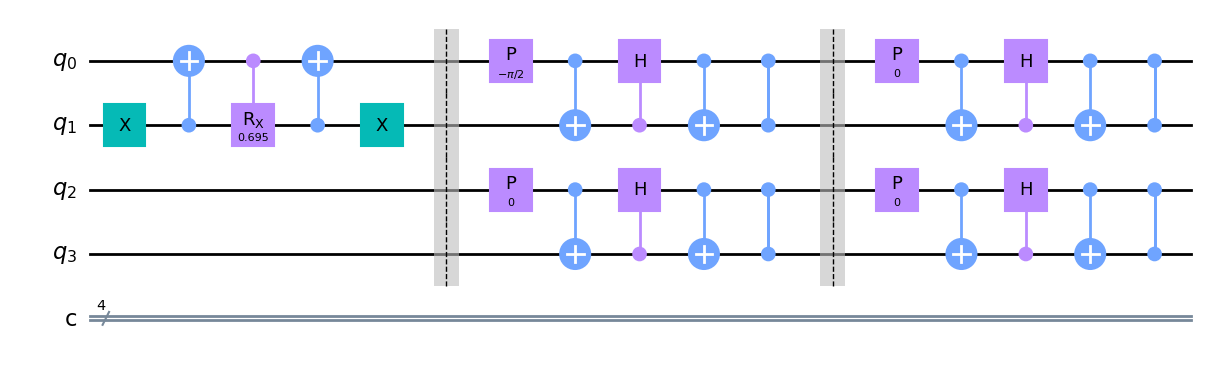

In [6]:
# Circuit built from diagrams in the paper
paperBasedCirc = QuantumCircuit(4, 4)
if lambd < 1:
    paperBasedCirc.x(3)
    paperBasedCirc.barrier()
applyDisentaglementGates(paperBasedCirc, lambd)
paperBasedCirc.draw("mpl")

In [7]:
lmbd = np.linspace(0, 1.8, 10)
sigmaz = []
for l in lmbd:
    sigmaz.append(ground_state(l, "qasm_simulator"))

# print(sigmaz)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


(0.0, 1.8)

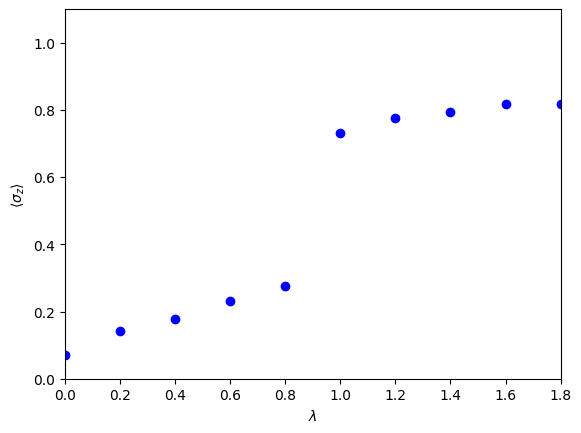

In [8]:
plt.plot(lmbd, sigmaz, "bo")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.xlabel("$\\lambda$")
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 1.8)

Job Status: job has successfully run


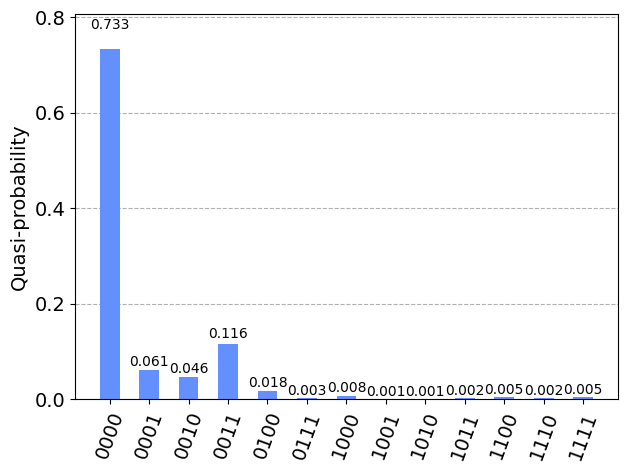

In [9]:
# Start up and initialize circuit
# Measurement
qcirc = QuantumCircuit(4, 4)
# Set correct ground state if lambda < 1
if lambd < 1:
    qcirc.x(3)
    qcirc.barrier()

    # Apply disentangling gates
applyDisentaglementGates(qcirc, lambd)
# Set measurement step
for i in range(0, 4):
    qcirc.measure(i, i)


# Using a fake backend provided with qiskit

backend = FakeManilaV2()
# Transipling essentially converts the circuit into a something that can run on the specific hardware specified
transpiled_circuit = transpile(qcirc, backend)
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()

shots = 1024
max_credits = 10  # Max number of credits to spend on execution
job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job)
result = job.result()
counts = result.get_counts(qcirc)

plot_distribution(counts)

# had to comment this part because qc is a local variable in groundstate function now - Bruna

In [10]:
phi = np.arccos(lambd / np.sqrt(1 + lambd**2)) / 2
# print(result.get_statevector(qc))
print("|0000> probability should be: ", np.cos(phi) ** 2)
print("|0011> probability should be: ", np.sin(phi) ** 2)

|0000> probability should be:  0.8841106397986879
|0011> probability should be:  0.11588936020131207


In [11]:
def wire(n=4):
    qcirc = QuantumCircuit(n, n)
    if lambd < 1:
        qcirc.x(3)
        qcirc.barrier()

    return qcirc


def time_evol(t, lambd, backend_name, qcirc):
    # This line seems to do everything time related for the transform
    qcirc.u(
        np.arccos(lambd / np.sqrt(1 + lambd**2)),
        np.pi / 2 + 4 * t * np.sqrt(1 + lambd**2),
        0,
        0,
    )
    qcirc.cx(0, 1)

    mag = []

    applyDisentaglementGates(qcirc, lambd)

    for i in range(0, 4):
        qcirc.measure(i, i)

    backend = Aer.get_backend(backend_name)

    shots = 1024
    max_credits = 10
    job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qcirc)

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots

    mag.append(M / 4)
    return mag


time = np.arange(0, 2.5, 0.05)
sigmaz = []

for t in time:
    sigmaz.append(time_evol(t, lambd, "qasm_simulator", wire()))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

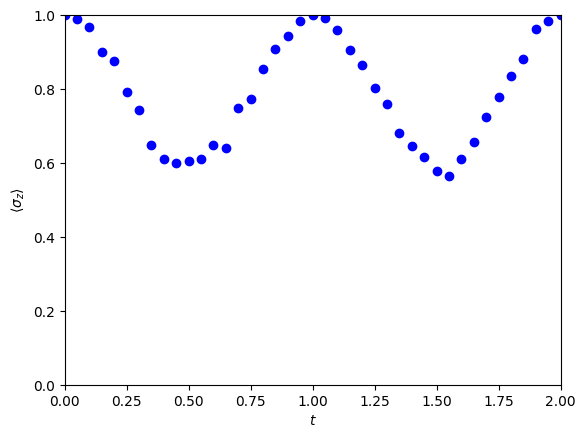

In [12]:
plt.plot(time, sigmaz, "bo")
plt.ylim(0, 1)
plt.xlim(0, 2)
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.xlabel("$t$")
plt.show()

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


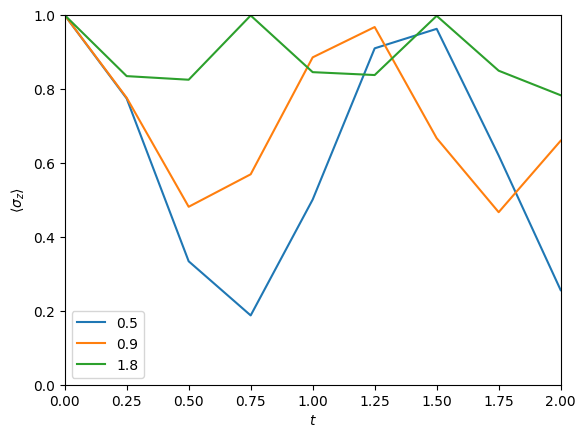

In [13]:
#def plot(mag, time, lamb):
#    plt.plot(time, mag, "bo")
#    plt.ylim(0, 1)
#    plt.xlim(0, 2)
#    plt.ylabel("$\\langle\\sigma_z\\rangle$, $\\lambda$={}".format(lamb))
#    plt.xlabel("$t$")
#    plt.show()


lambdas = [0.5, 0.9, 1.8]
times = np.linspace(0, 2, 9)

#for i in lambda_list:
#    sigmaz = []
#    for j in time_list:
#        sigmaz.append(time_evol(j, i, "qasm_simulator", wire()))
#    plot(sigmaz, time_list, i)


fig, ax = plt.subplots()
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
ax.set_xlabel("$t$")
ax.set_ylabel("$\\langle\\sigma_z\\rangle$")

for l in lambdas:
    mag = []
    for t in times:
        mag.append(time_evol(t, l, "qasm_simulator", wire()))
    
    ax.plot(times, mag, label=l)

ax.legend()

plt.show()